In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class DiffGrad(optimizer_v2.OptimizerV2):
    def __init__(self,
                 learning_rate=0.1,
                 beta_1=0.95,
                 beta_2=0.999,
                 epsilon=1e-7,
                 name='DiffGrad',
                 **kwargs):
        super(DiffGrad, self).__init__(name, **kwargs)
        #self.version = version
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self.epsilon = epsilon or backend_config.epsilon()

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm', initializer='zeros')
        for var in var_list:
            self.add_slot(var, 'v', initializer='zeros')
        for var in var_list:
            self.add_slot(var, 'prev_g')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(DiffGrad, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)
        lr = (apply_state[(var_device, var_dtype)]['lr_t'] *
              (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
        apply_state[(var_device, var_dtype)].update(dict(
            lr=lr,
            epsilon=ops.convert_to_tensor(self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t
        ))

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(DiffGrad, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values,
                               use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values,
                               use_locking=self._use_locking)

        # diffgrad
        prev_g = self.get_slot(var, 'prev_g')
        dfc = 1.0 / (1.0 + math_ops.exp(-math_ops.abs(prev_g - grad)))

        v_sqrt = math_ops.sqrt(v_t)
        var_update = state_ops.assign_sub(
            var, coefficients['lr'] * m_t * dfc / (v_sqrt + coefficients['epsilon']),
            use_locking=self._use_locking)

        new_prev_g = state_ops.assign(prev_g, grad, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t, new_prev_g])

    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        raise RuntimeError('This optimizer does not support sparse gradients.')

    def get_config(self):
        config = super(DiffGrad, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'epsilon': self.epsilon,
        })
        return config

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config



from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops

from tensorflow.python.util.tf_export import keras_export
from keras.optimizer_v2 import optimizer_v2


@keras_export('keras.optimizers.Diffgrad')
class DiffGrad(optimizer_v2.OptimizerV2):
    def __init__(self,
                 learning_rate=0.1,
                 beta_1=0.95,
                 beta_2=0.999,
                 epsilon=1e-7,
                 name='DiffGrad',
                 diff_version=0,
                 **kwargs):
        super(DiffGrad, self).__init__(name, **kwargs)
        #self.version = version
        self.d_version = diff_version
        if self.d_version<0 or self.d_version>5:
          raise RuntimeError("No diffGrad version ",self.d_version)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self.epsilon = epsilon or backend_config.epsilon()

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Create slots for previous g (gradient)
        # Create slots for sum of g and sum of g square
        # Separate for-loops to respect the ordering of slot variables from v1.
        # See if slot can be controlled by version for sig_1 and sig_2
        for var in var_list:
            self.add_slot(var,'m', initializer='zeros')
        for var in var_list:
            self.add_slot(var,'v', initializer='zeros')
        for var in var_list:
            self.add_slot(var,'prev_g')
        if self.d_version>=3:
          for var in var_list:
              self.add_slot(var,'sig_1', initializer='zeros')
          for var in var_list:
              self.add_slot(var,'sig_2', initializer='zeros')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(DiffGrad, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)
        lr = (apply_state[(var_device, var_dtype)]['lr_t'] *
              (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
        apply_state[(var_device, var_dtype)].update(dict(
            lr=lr,
            epsilon=ops.convert_to_tensor(self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t
        ))

    def set_weights(self, weights):
        return #modify values
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(DiffGrad, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values,
                               use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values,
                               use_locking=self._use_locking)

        # diffgrad
        prev_g = self.get_slot(var, 'prev_g')

        #dfc = 1.0 / (1.0 + math_ops.exp(-math_ops.abs(prev_g - grad)))
        dfc = 1.0
        g_mu=0.0
        g_sig=1.0
        if(self.d_version>=3):
          t=math_ops.cast(self.iterations + 1, var_dtype)
          sig_1=self.get_slot(var,'sig_1')
          sig_2=self.get_slot(var,'sig_2')
          g_mu=(sig_1/t)
          g_sig=(sig_2/t)-g_mu

        if(self.d_version==0):
          dfc = 1.0 / (1.0 + math_ops.exp(-math_ops.abs(prev_g - grad)))
        if(self.d_version==1):
          dfc = 1.0 / (1.0 + math_ops.exp(-(prev_g - grad)))
        if(self.d_version==2):
          dfc = (9.0 / (1.0 + math_ops.exp((-math_ops.abs(prev_g - grad))*0.5))) +0.4
        if(self.d_version==3):
          dfc = 1.0 / (1.0 + math_ops.exp(-(g_sig*math_ops.abs(prev_g - grad)-g_mu)))
        if(self.d_version==4):
          dfc = 1.0 / (1.0 + math_ops.exp(-(g_sig*g_sig*math_ops.abs(prev_g - grad)-g_mu)))
        if(self.d_version==5):
          dfc = 1.0 / (1.0 + math_ops.exp(-(math_ops.sqrt(g_sig)*math_ops.abs(prev_g - grad)-g_mu)))





        v_sqrt = math_ops.sqrt(v_t)
        var_update = state_ops.assign_sub(
            var, coefficients['lr'] * m_t * dfc / (v_sqrt + coefficients['epsilon']),
            use_locking=self._use_locking)

        new_prev_g = state_ops.assign(prev_g, grad, use_locking=self._use_locking)

        if(self.d_version>=3):
          new_sig_1=state_ops.assign(sig_1, sig_1+grad, use_locking=self._use_locking)
          new_sig_2=state_ops.assign(sig_2, sig_2+grad*grad, use_locking=self._use_locking)
          return control_flow_ops.group(*[var_update, m_t, v_t, new_prev_g,new_sig_1,new_sig_2])

        else:
          return control_flow_ops.group(*[var_update, m_t, v_t, new_prev_g])
    def get_config(self):
        config = super(DiffGrad, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'epsilon': self.epsilon,
            'diff_version': self.d_version
        })
        return config

In [ ]:
def F1(x):
    if(x<=0):
        return (x+0.3)**2
    else:
        return ((x-0.2)**2)+0.05
def F1d(x):
    if(x<=0):
        return (x+0.3)*2
    else:
        return (x-0.2)*2

def F2(x):
    if(x<=-0.9):
        return -40*x-35.15
    else:
        return x*x*x + x*math_ops.sin(8*x)+0.85
def F2d(x):
    if(x<=-0.9):
        return -40.0*(x/x)
    else:
        return 3*x*x + 8*x*math_ops.cos(8*x) + math_ops.sin(8*x)

def F3(x):
    if(x<=-0.50):
        return x*x
    if(x>-0.5 and x<=-0.4):
        return 0.75+x
    if(x>-0.4 and x<=0):
        return -(7*x/8)
    if(x>0 and x<=0.4):
        return (7*x/8)
    if(x>0.4 and x<=0.5):
        return 0.75-x
    else:
        return x*x

def F3d(x):
    if(x<=-0.50):
        return 2*x
    if(x>-0.5 and x<=-0.4):
        return 1
    if(x>-0.4 and x<=0):
        return -(7/8)
    if(x>0 and x<=0.4):
        return (7/8)
    if(x>0.4 and x<=0.5):
        return -1
    else:
        return 2*x

In [ ]:
def f_range(st,en,step=1):
    x=[]
    xi=st
    while(xi<=en):
        x.append(xi)
        xi+=step
    return x

2
2
2


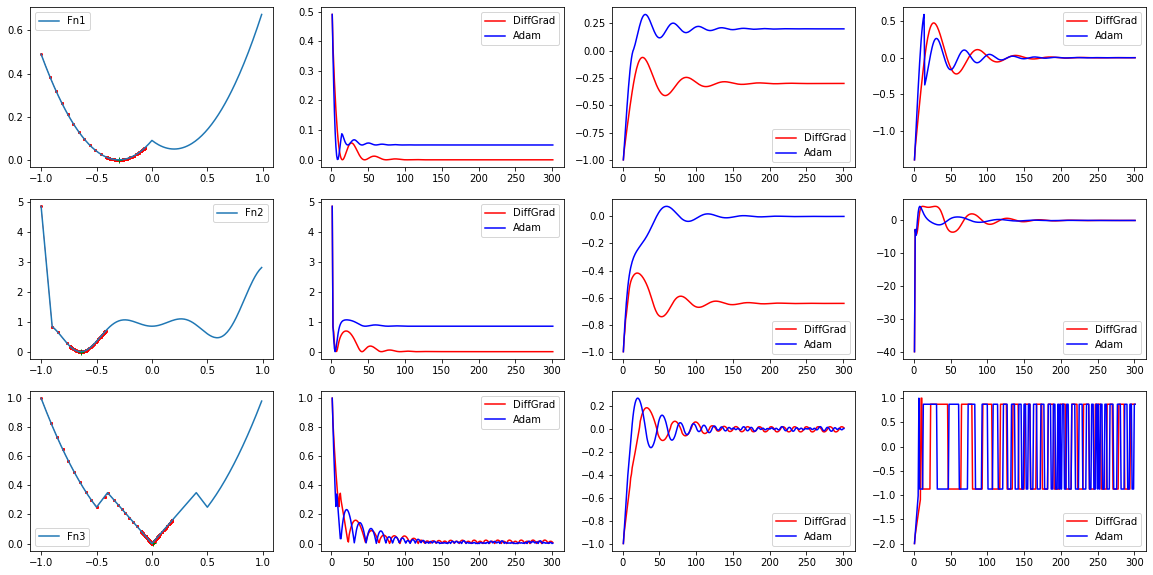

In [ ]:
fig, axs = plt.subplots(3, 4)

####################################################
opt=DiffGrad()
opt2=tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.95,beta_2=0.999,epsilon=1e-07,amsgrad=False)

var1 = tf.Variable(-1.0)
loss = lambda: F1(var1)
var2 = tf.Variable(-1.0)
loss2 = lambda: F1(var2)
wt=[]
wt2=[]
wt.append(var1.numpy())
wt2.append(var2.numpy())

for i in range(300):
  step_count = opt.minimize(loss, [var1]).numpy()
  step_count2 = opt2.minimize(loss2, [var2]).numpy()
  wt.append(var1.numpy())
  wt2.append(var2.numpy())
  #print(var1.numpy(),step_count,var2.numpy(),step_count2)
print(len(wt[1:1+2]))
y_op=[]
for i in wt:
  y_op.append(F1(i))
for i in range(len(wt)-1):
  axs[0, 0].plot(wt[i:i+2],y_op[i:i+2],'ro-',linewidth=0.5, markersize=2)
axs[0, 0].plot(wt[-1],y_op[-1],'g+',linewidth=2, markersize=6)
x1=f_range(-1,1,0.01)
y1=[]
for i in x1:
  y1.append(F1(i))
axs[0, 0].plot(x1,y1,label="Fn1")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append(F1(i))
axs[0, 1].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F1(i))
axs[0, 1].plot(x1,y1,'b-',label="Adam")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append((i))
axs[0, 2].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append((i))
axs[0, 2].plot(x1,y1,'b-',label="Adam")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append(F1d(i))
axs[0, 3].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F1d(i))
axs[0, 3].plot(x1,y1,'b-',label="Adam")

####################################################
opt=DiffGrad()
opt2=tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.95,beta_2=0.999,epsilon=1e-07,amsgrad=False)

var1 = tf.Variable(-1.0)
loss = lambda: F2(var1)
var2 = tf.Variable(-1.0)
loss2 = lambda: F2(var2)
wt=[]
wt2=[]
wt.append(var1.numpy())
wt2.append(var2.numpy())

for i in range(300):
  step_count = opt.minimize(loss, [var1]).numpy()
  step_count2 = opt2.minimize(loss2, [var2]).numpy()
  wt.append(var1.numpy())
  wt2.append(var2.numpy())
  #print(var1.numpy(),step_count,var2.numpy(),step_count2)
print(len(wt[1:1+2]))
y_op=[]
for i in wt:
  y_op.append(F2(i))
for i in range(len(wt)-1):
  axs[1, 0].plot(wt[i:i+2],y_op[i:i+2],'ro-',linewidth=0.5, markersize=2)
axs[1, 0].plot(wt[-1],y_op[-1],'g+',linewidth=2, markersize=6)
x1=f_range(-1,1,0.01)
y1=[]
for i in x1:
  y1.append(F2(i))
axs[1, 0].plot(x1,y1,label="Fn2")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append(F2(i))
axs[1, 1].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F2(i))
axs[1, 1].plot(x1,y1,'b-',label="Adam")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append((i))
axs[1, 2].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append((i))
axs[1, 2].plot(x1,y1,'b-',label="Adam")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append(F2d(i))
axs[1, 3].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F2d(i))
axs[1, 3].plot(x1,y1,'b-',label="Adam")

####################################################
opt=DiffGrad()
opt2=tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.95,beta_2=0.999,epsilon=1e-07,amsgrad=False)

var1 = tf.Variable(-1.0)
loss = lambda: F3(var1)
var2 = tf.Variable(-1.0)
loss2 = lambda: F3(var2)
wt=[]
wt2=[]
wt.append(var1.numpy())
wt2.append(var2.numpy())

for i in range(300):
  step_count = opt.minimize(loss, [var1]).numpy()
  step_count2 = opt2.minimize(loss2, [var2]).numpy()
  wt.append(var1.numpy())
  wt2.append(var2.numpy())
  #print(var1.numpy(),step_count,var2.numpy(),step_count2)
print(len(wt[1:1+2]))
y_op=[]
for i in wt:
  y_op.append(F3(i))
for i in range(len(wt)-1):
  axs[2, 0].plot(wt[i:i+2],y_op[i:i+2],'ro-',linewidth=0.5, markersize=2)
axs[2, 0].plot(wt[-1],y_op[-1],'g+',linewidth=2, markersize=6)
x1=f_range(-1,1,0.01)
y1=[]
for i in x1:
  y1.append(F3(i))
axs[2, 0].plot(x1,y1,label="Fn3")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append(F3(i))
axs[2, 1].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F3(i))
axs[2, 1].plot(x1,y1,'b-',label="Adam")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append((i))
axs[2, 2].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append((i))
axs[2, 2].plot(x1,y1,'b-',label="Adam")

x1=f_range(1,len(wt),1)
y1=[]
for i in wt:
  y1.append(F3d(i))
axs[2, 3].plot(x1,y1,'r-',label="DiffGrad")
x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F3d(i))
axs[2, 3].plot(x1,y1,'b-',label="Adam")

for i in range(3):
  for j in range(4):
    axs[i,j].legend()

fig.set_size_inches(20,10)


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


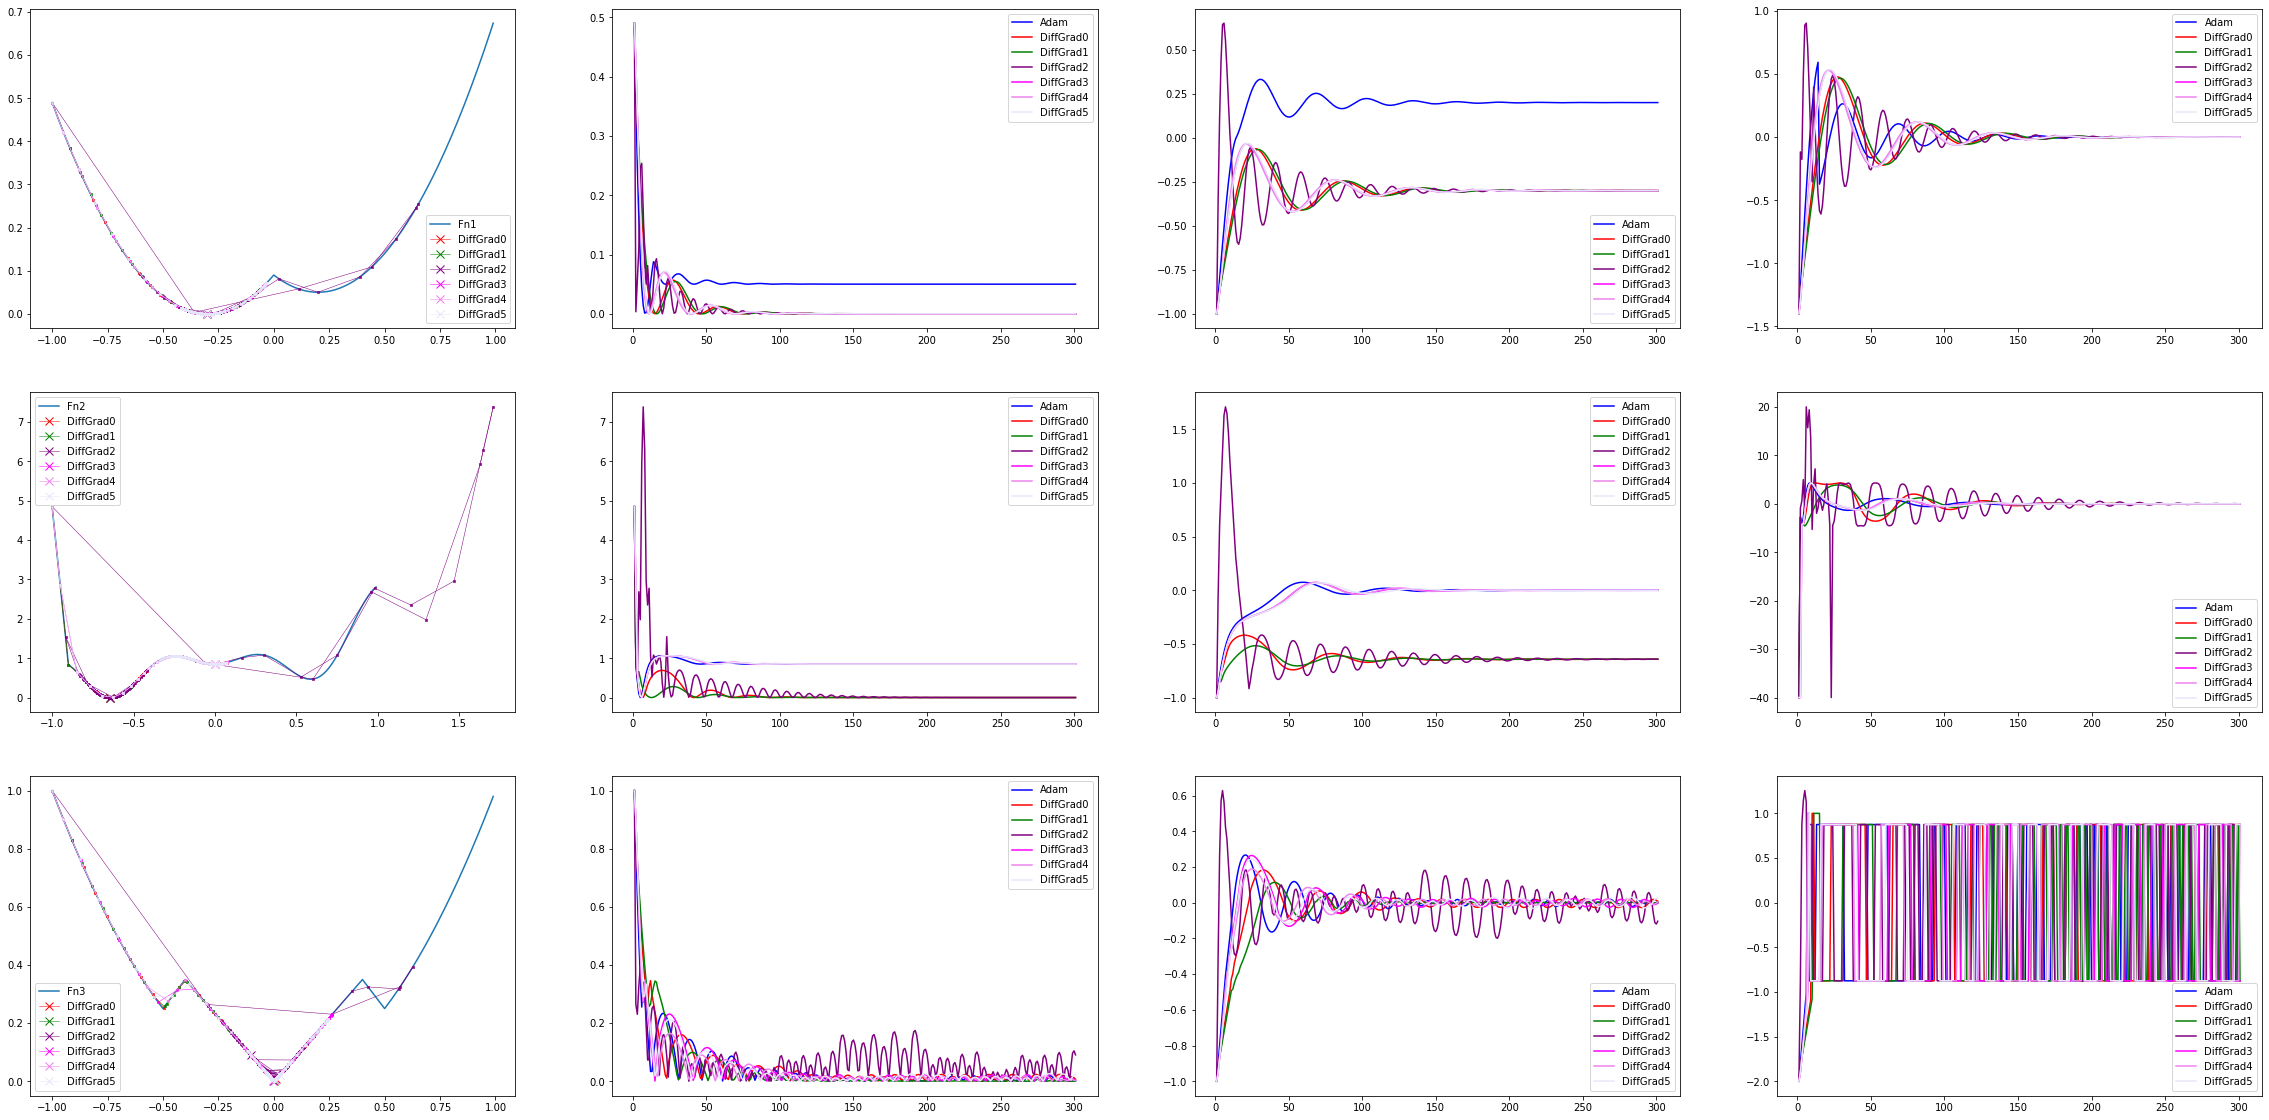

In [ ]:
l_col=['red','green','purple','magenta','violet','lavender']
fig, axs = plt.subplots(3, 4)
m_st=300
####################################################

opt2=tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.95,beta_2=0.999,epsilon=1e-07,amsgrad=False)

var2 = tf.Variable(-1.0)
loss2 = lambda: F1(var2)

wt2=[]

wt2.append(var2.numpy())

for i in range(m_st):
  step_count2 = opt2.minimize(loss2, [var2]).numpy()
  wt2.append(var2.numpy())

x1=f_range(-1,1,0.01)
y1=[]
for i in x1:
  y1.append(F1(i))
axs[0, 0].plot(x1,y1,label="Fn1")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F1(i))
axs[0, 1].plot(x1,y1,'b-',label="Adam")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append((i))
axs[0, 2].plot(x1,y1,'b-',label="Adam")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F1d(i))
axs[0, 3].plot(x1,y1,'b-',label="Adam")

####################################################

opt2=tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.95,beta_2=0.999,epsilon=1e-07,amsgrad=False)


var2 = tf.Variable(-1.0)
loss2 = lambda: F2(var2)

wt2=[]

wt2.append(var2.numpy())

for i in range(m_st):
  step_count2 = opt2.minimize(loss2, [var2]).numpy()
  wt2.append(var2.numpy())


x1=f_range(-1,1,0.01)
y1=[]
for i in x1:
  y1.append(F2(i))
axs[1, 0].plot(x1,y1,label="Fn2")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F2(i))
axs[1, 1].plot(x1,y1,'b-',label="Adam")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append((i))
axs[1, 2].plot(x1,y1,'b-',label="Adam")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F2d(i))
axs[1, 3].plot(x1,y1,'b-',label="Adam")

####################################################

opt2=tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.95,beta_2=0.999,epsilon=1e-07,amsgrad=False)


var2 = tf.Variable(-1.0)
loss2 = lambda: F3(var2)

wt2=[]

wt2.append(var2.numpy())

for i in range(m_st):
  step_count2 = opt2.minimize(loss2, [var2]).numpy()
  wt2.append(var2.numpy())
  #print(var1.numpy(),step_count,var2.numpy(),step_count2)

x1=f_range(-1,1,0.01)
y1=[]
for i in x1:
  y1.append(F3(i))
axs[2, 0].plot(x1,y1,label="Fn3")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F3(i))
axs[2, 1].plot(x1,y1,'b-',label="Adam")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append((i))
axs[2, 2].plot(x1,y1,'b-',label="Adam")


x1=f_range(1,len(wt2),1)
y1=[]
for i in wt2:
  y1.append(F3d(i))
axs[2, 3].plot(x1,y1,'b-',label="Adam")


for ver in range (6):
  ####################################################
  opt=DiffGrad(diff_version=ver)


  var1 = tf.Variable(-1.0)
  loss = lambda: F1(var1)

  wt=[]

  wt.append(var1.numpy())


  for i in range(m_st):
    step_count = opt.minimize(loss, [var1]).numpy()

    wt.append(var1.numpy())

    #print(var1.numpy(),step_count,var2.numpy(),step_count2)
  print(len(wt[1:1+2]))
  y_op=[]
  for i in wt:
    y_op.append(F1(i))
  for i in range(len(wt)-1):
    axs[0, 0].plot(wt[i:i+2],y_op[i:i+2], color=l_col[ver], linestyle='solid', marker='x',linewidth=0.5, markersize=2)
  axs[0, 0].plot(wt[-1],y_op[-1], color=l_col[ver], linestyle='solid', marker='x',linewidth=0.5, markersize=8,label="DiffGrad"+str(ver))

  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append(F1(i))
  axs[0, 1].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append((i))
  axs[0, 2].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append(F1d(i))
  axs[0, 3].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


  ####################################################
  opt=DiffGrad(diff_version=ver)

  var1 = tf.Variable(-1.0)
  loss = lambda: F2(var1)

  wt=[]

  wt.append(var1.numpy())


  for i in range(m_st):
    step_count = opt.minimize(loss, [var1]).numpy()

    wt.append(var1.numpy())

    #print(var1.numpy(),step_count,var2.numpy(),step_count2)
  print(len(wt[1:1+2]))
  y_op=[]
  for i in wt:
    y_op.append(F2(i))
  for i in range(len(wt)-1):
    axs[1, 0].plot(wt[i:i+2],y_op[i:i+2], color=l_col[ver], linestyle='solid', marker='x',linewidth=0.5, markersize=2)
  axs[1, 0].plot(wt[-1],y_op[-1], color=l_col[ver], linestyle='solid', marker='x',linewidth=0.5, markersize=8,label="DiffGrad"+str(ver))


  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append(F2(i))
  axs[1, 1].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append((i))
  axs[1, 2].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append(F2d(i))
  axs[1, 3].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


  ####################################################
  opt=DiffGrad(diff_version=ver)


  var1 = tf.Variable(-1.0)
  loss = lambda: F3(var1)

  wt=[]

  wt.append(var1.numpy())


  for i in range(m_st):
    step_count = opt.minimize(loss, [var1]).numpy()

    wt.append(var1.numpy())

    #print(var1.numpy(),step_count,var2.numpy(),step_count2)
  print(len(wt[1:1+2]))
  y_op=[]
  for i in wt:
    y_op.append(F3(i))
  for i in range(len(wt)-1):
    axs[2, 0].plot(wt[i:i+2],y_op[i:i+2], color=l_col[ver], linestyle='solid', marker='x',linewidth=0.5, markersize=2)
  axs[2, 0].plot(wt[-1],y_op[-1], color=l_col[ver], linestyle='solid', marker='x',linewidth=0.5, markersize=8,label="DiffGrad"+str(ver))


  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append(F3(i))
  axs[2, 1].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append((i))
  axs[2, 2].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


  x1=f_range(1,len(wt),1)
  y1=[]
  for i in wt:
    y1.append(F3d(i))
  axs[2, 3].plot(x1,y1, color=l_col[ver], linestyle='solid',label="DiffGrad"+str(ver))


for i in range(3):
  for j in range(4):
    axs[i,j].legend()

fig.set_size_inches(40,20)

In [ ]:
!pip install np_utils

     |████████████████████████████████| 61 kB 8.1 MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57131 sha256=b2c47a735f2321e3ea74c0933681d5275cf89d024fd53532084797ce53edfcfd
  Stored in directory: /root/.cache/pip/wheels/8c/4e/ef/095c24693723c329f4cdc1079861cdbb2487d4b41b2496a4e7
Successfully built np-utils


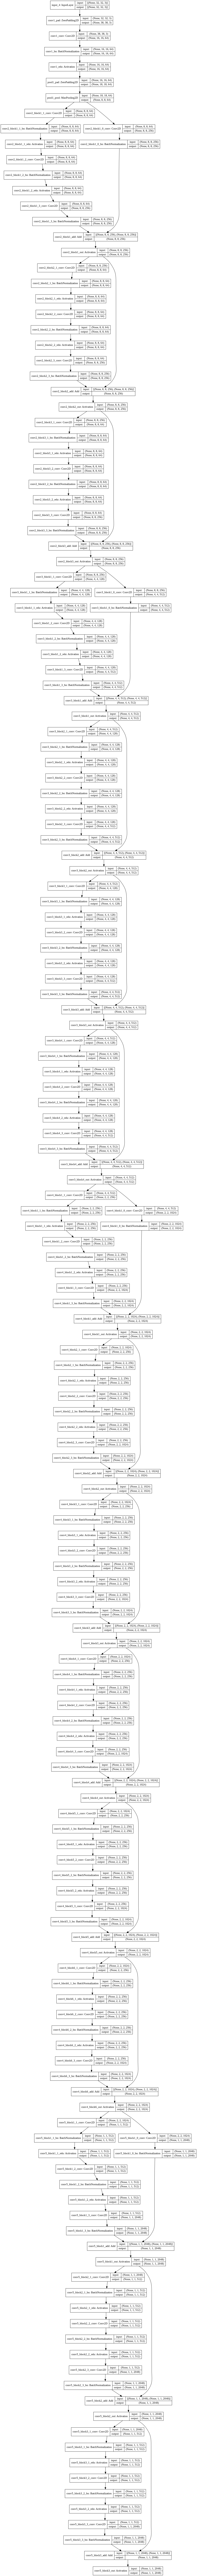

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10, cifar100

from tensorflow.keras.models import load_model
import np_utils
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np

resnet50=ResNet50( include_top=False, input_shape=(32, 32, 3))

#resnet50.summary()
tf.keras.utils.plot_model(resnet50,show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None)

In [ ]:
resnet50=ResNet50(weights=None, input_shape=(32, 32, 3), classes=10)

resnet50.summary()

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
from tensorflow.keras.utils import to_categorical

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
def scheduler(epoch, lr):
  if epoch < 80:
    return 1e-3
  else:
    return 1e-4
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
ver=0

opt=DiffGrad(diff_version=ver)

In [ ]:
ver=3

opt=DiffGrad(diff_version=ver)



resnet50.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

history = resnet50.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test), callbacks=[callback])